In [130]:
!pip install gymnasium

In [131]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [132]:
#!pip install --upgrade ptan torch
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

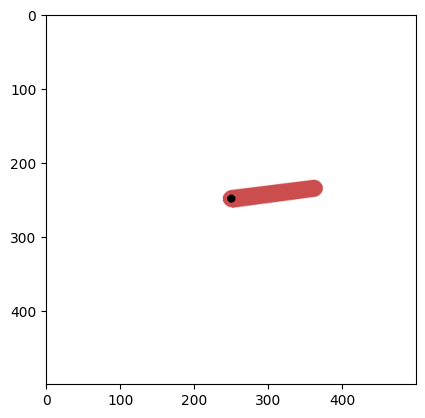

In [181]:
env=gym.make('Pendulum-v1',render_mode='rgb_array')
env.reset()
plt.imshow(env.render())

In [182]:
env.observation_space

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)

In [183]:
env.observation_space.shape[0]

3

In [184]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [185]:
env.action_space.shape[0]

1

In [186]:
env.reward_range

(-inf, inf)

In [187]:
a=env.action_space.sample()
a

array([1.4239345], dtype=float32)

In [188]:
env.step(a)

(array([ 0.10077848, -0.99490887, -0.50778806], dtype=float32),
 -2.08853511668228,
 False,
 False,
 {})

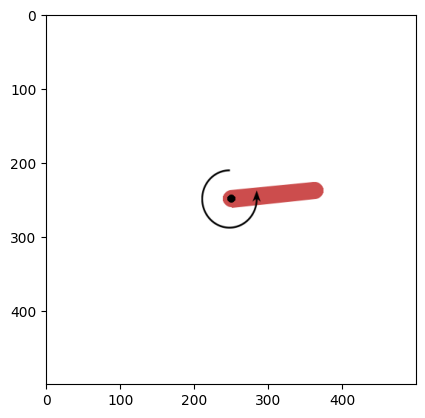

In [189]:
plt.imshow(env.render())

In [190]:
env=gym.make('Pendulum-v1',render_mode='human')
env.reset()
for t in range(200):
  a=env.action_space.sample()
  env.step(a)

In [191]:
n_s=env.observation_space.shape[0]
n_a=env.action_space.shape[0]
n_epi=200
disc=0.9
n_t=200
rho=0.01
sigma=3

In [192]:
def get_bat(replay,n_bat):
  bat=random.sample(replay,n_bat)
  s_bat=torch.Tensor([s for (s,a,r,s1) in bat])
  a_bat=torch.Tensor([a for (s,a,r,s1) in bat])
  r_bat=torch.Tensor([r for (s,a,r,s1) in bat])
  s1_bat=torch.Tensor([s1 for (s,a,r,s1) in bat])
  return s_bat,a_bat,r_bat,s1_bat

In [193]:
def tar_up(model_main,model_tar,rho):
  for w in model_tar.state_dict().keys():
    eval('model_tar.'+ w + '.data.mul_((1-rho))')
    eval('model_tar.'+ w + '.data.add_(rho*model_main.' + w + '.data)')

In [194]:
n_buf=10000
n_bat=32

In [195]:
replay=deque(maxlen=n_buf)

In [196]:
class ActorNet(nn.Module):
  def __init__(self,n_s,n_a):
    super(ActorNet,self).__init__()
    self.h1=nn.Linear(n_s,30)
    self.h1.weight.data.normal_(0,0.1)
    self.out=nn.Linear(30,n_a)
    self.out.weight.data.normal_(0,0.1)
  def forward(self,s):
    x=torch.relu(self.h1(s))
    x=self.out(x)
    x=torch.tanh(x)
    a=x*2
    return a

In [197]:
class CriticNet(nn.Module):
  def __init__(self,n_s,n_a):
    super(CriticNet,self).__init__()
    self.h1s=nn.Linear(n_s,30)
    self.h1s.weight.data.normal_(0,0.1)
    self.h1a=nn.Linear(n_a,30)
    self.h1a.weight.data.normal_(0,0.1)
    self.out=nn.Linear(30,1)
    self.out.weight.data.normal_(0,0.1)
  def forward(self,s,a):
    xs=self.h1s(s)
    xa=self.h1a(a)
    q=self.out(torch.relu(xs+xa))
    return q

In [198]:
A_main=ActorNet(n_s,n_a)

In [199]:
A_tar=copy.deepcopy(A_main)
A_tar.load_state_dict(A_main.state_dict())

<All keys matched successfully>

In [200]:
Q_main=CriticNet(n_s,n_a)

In [201]:
Q_tar=copy.deepcopy(Q_main)
Q_tar.load_state_dict(Q_main.state_dict())

<All keys matched successfully>

In [202]:
losses_a=[]
losses_c=[]

In [203]:
opt_a=torch.optim.Adam(A_main.parameters(),lr=1e-3)

In [204]:
loss_fnc=nn.MSELoss()
opt_c=torch.optim.Adam(Q_main.parameters(),lr=1e-3)

In [205]:
env=gym.make('Pendulum-v1',render_mode=None)
Gs=[]

In [206]:
for i in range(n_epi):
  s,_=env.reset()
  G=0
  for t in range(n_t):
    a=A_main(torch.Tensor(s)).detach()
    a0=np.clip(np.random.normal(a,sigma),-2,2)
    s1,r,_,_,_=env.step(a0)
    replay.append((s,a0,[r/10],s1))
    s=s1
    if len(replay)>=n_buf:
      s_bat,a0_bat,r_bat,s1_bat=get_bat(replay,n_bat)
      a_bat=A_main(s_bat)
      q_bat=Q_main(s_bat,a_bat)
      loss_a=-torch.mean(q_bat)
      opt_a.zero_grad()
      loss_a.backward()
      opt_a.step()
      losses_a.append(loss_a.item())
      y_hat=Q_main(s_bat,a0_bat)
      with torch.no_grad():
        a1_bat=A_tar(s1_bat)
        q1_bat=Q_tar(s1_bat,a1_bat)
        y=r_bat+disc*q1_bat
      loss_c=loss_fnc(y.detach(),y_hat)
      opt_c.zero_grad()
      loss_c.backward()
      opt_c.step()
      losses_c.append(loss_c.item())
      tar_up(A_main,A_tar,rho)
      tar_up(Q_main,Q_tar,rho)
      sigma*=0.9995
    G+=r
  print('Episode:',i,', G: %i' %G,', sigma: %.2f' %sigma)
  Gs.append(G)
  clear_output(wait=True)

Episode: 199 , G: -136 , sigma: 0.00


Text(0, 0.5, 'Loss')

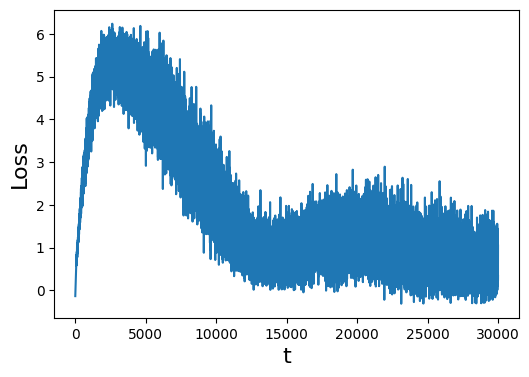

In [207]:
plt.figure(figsize=(6,4))
plt.plot(losses_a)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

Text(0, 0.5, 'Loss')

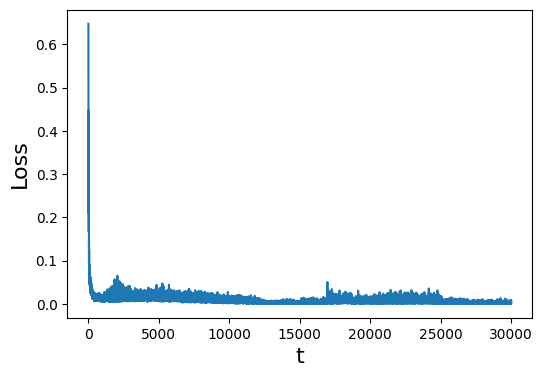

In [208]:
plt.figure(figsize=(6,4))
plt.plot(losses_c)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

Text(0, 0.5, 'G')

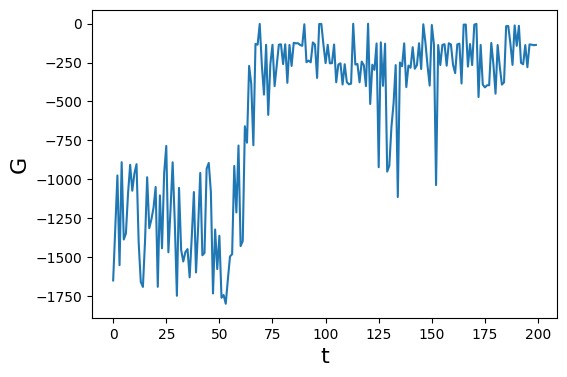

In [209]:
plt.figure(figsize=(6,4))
plt.plot(Gs)
plt.xlabel("t",fontsize=16)
plt.ylabel("G",fontsize=16)

In [210]:
def test_agent(model,n_t=200,mode='human',display=True):
  env=gym.make('Pendulum-v1',render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    a=np.clip(model(torch.Tensor(s)).data.numpy(),-2,2)
    s1,r,done,_,info=env.step(a)
    if display:
      print('t=',t,'\n','s=',s,'\n','a=',a,'\n','r=',r,'\n','s\=',s1)
      clear_output(wait=True)
    if np.sum(np.fabs(s1-s))<0.01:
      if display:
        print('Your Steps: %s' %(t+1))
      break
    s=s1
  return t+1

In [211]:
test_agent(A_main)

Your Steps: 36


36

100%|██████████| 100/100 [00:01<00:00, 60.88it/s]


Average steps: 56.79


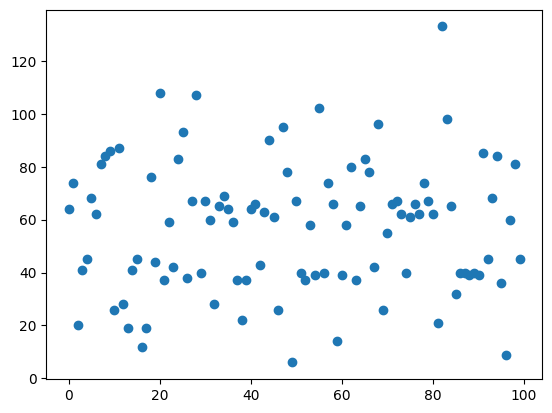

In [212]:
n_game=100
scores=[]
s,_=env.reset()
for i in tqdm(range(n_game)):
  score=test_agent(A_main,mode=None,display=False)
  scores.append(score)
print('\nAverage steps:', np.mean(scores))
plt.scatter(np.arange(len(scores)),scores)